This code largely follows the work of github user purnasi at https://github.com/purnasai/Dino_V2/blob/main/2.PCA_visualization.ipynb .

In [34]:
# Imports
import torch
import torch.nn as nn
from utils import *
torch.cuda.empty_cache()


import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

from typing import Tuple, List, Any, TypedDict

IMG_SIZE = 518
PATCH_SIZE  = 14
PATCH_H, PATCH_W = IMG_SIZE // PATCH_SIZE, IMG_SIZE // PATCH_SIZE
FEAT_DIM = 384

transform = get_input_transform(520, IMG_SIZE)

DINOv2 expects images to be a multiple of 14 (the patch size). It was trained at 224x244 and then the final 10k train runs were run at 516x516. The smallest distilled model, `dinov2_vits14` has a feature dimension of 384. They also normalize the data before feeding it into the model. We do the same here, adding an unnormalize option for visualizing.

Load model here. Add '_lc' to load the ImageNet 1k linear classifier version, but we just want the features.

In [24]:
dinov2_vits14: nn.Module  = torch.hub.load("facebookresearch/dinov2", "dinov2_vits14")
dinov2_vits14.eval()
dinov2_vits14.cuda()
pass # here to flush stdout

Using cache found in /home/ronan/.cache/torch/hub/facebookresearch_dinov2_main


In [25]:
def get_img_features(img_tensor: torch.Tensor, model: Any) -> np.ndarray:
    # feed (processed) img tensor into DINOV2, get the features and detach
    features_dict = model.forward_features(img_tensor.unsqueeze(0))
    features = features_dict["x_norm_patchtokens"]
    return features.detach().cpu().numpy()

In [26]:
class PlotParams(TypedDict): # little helper class for typed plotting
    colour: str
    title: str

plane_params: PlotParams = {'colour': 'C0', 'title': 'Plane'}
sketch_params: PlotParams = {'colour': 'C1', 'title': 'Sketch'}
sofc_params: PlotParams = {'colour': 'C2', 'title': 'SOFC'}

plot_params: List[PlotParams] = [plane_params, sketch_params, sofc_params]

Some generic plotting code here

In [32]:
def get_pca_features(feat_arr: np.ndarray, n_patches_h: int, n_patches_w: int, feat_dim: int, n_components: int=3) -> np.ndarray:
    #  Take np array output of DINOv2 and compute $n_components principal components.
    reshaped_features: np.ndarray = feat_arr.reshape(n_patches_h * n_patches_w, feat_dim)
    pca = PCA(n_components=n_components)
    pca.fit(reshaped_features)
    pca_features = pca.transform(reshaped_features)
    return pca_features

def plot_pca_hists(pcas: List[np.ndarray], plot_params: List[PlotParams], n_components: int=3, show_first: bool=True) -> None:
    # Loop through each of the pcas, plot an image of the pcas and the distributions of the first 3 components.
    n_imgs = len(pcas)
    n_plots = n_components + 1 if show_first is True else n_components
    fig, axs = plt.subplots(n_imgs, n_plots)
    fig.set_size_inches(12, 4)
    fig.tight_layout()
    for i in range(n_imgs):
        params = plot_params[i]
        for j in range(n_plots):
            ax: plt.axes.Axes = axs[i, j] if n_imgs > 1 else axs[j]
            if j == 0 and show_first: # draw first component spatially
                normed = normalise_pca(pcas[i])
                ax.set_title(params['title'])
                ax.imshow(normed[:, :].reshape(PATCH_H, PATCH_W, 3))
                ax.set_axis_off()
            else: # plot hist
                component = pcas[i][:, j - 1]
                ax.hist(component, bins=20, color=params['colour'])
                if i == 0:
                    ax.set_title(f"PCA Component {j}")

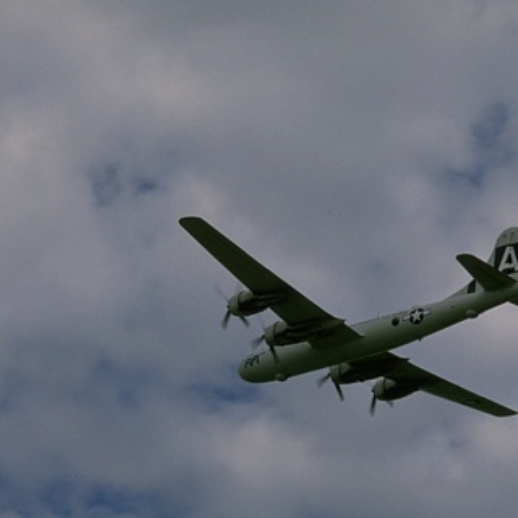

In [33]:
plane_tensor, plane_img = load_image("data/plane.jpg", transform)
plane_tensor = plane_tensor.to('cuda')

sofc_tensor, sofc_img = load_image("data/sofc.jpg", transform)
sofc_tensor = sofc_tensor.to('cuda')

sketch_tensor, sketch_img = load_image("data/sketch.jpg", transform)
sketch_tensor = sketch_tensor.to('cuda')
plane_img

In [35]:
pcas: List[np.ndarray] = []

for tensor in [plane_tensor, sketch_tensor, sofc_tensor]:
    dino_features_arr = get_img_features(tensor, dinov2_vits14)
    pca_features_arr = get_pca_features(dino_features_arr, PATCH_H, PATCH_W, FEAT_DIM)
    pcas.append(pca_features_arr)

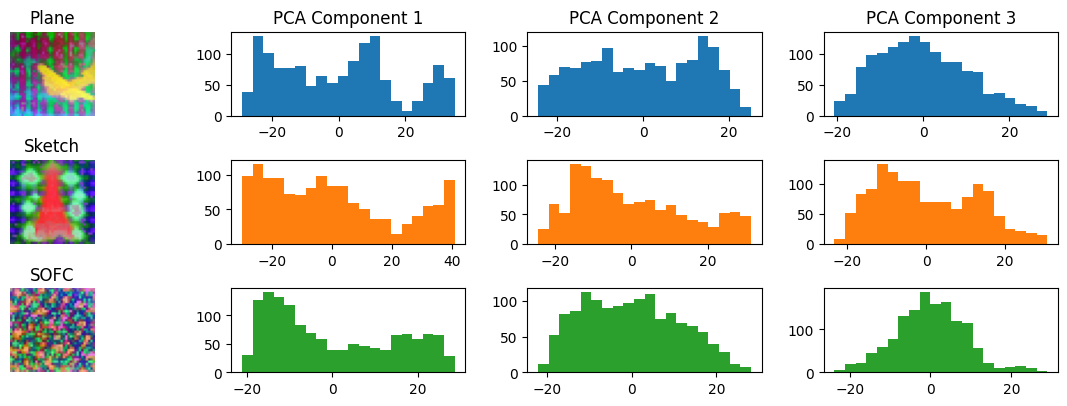

In [36]:
plot_pca_hists(pcas, plot_params)

Paper and repo above suggest the 1st PCA component tends to be the foreground/background distinction, and that the minima in the histogram is the cutoff point. Here we threshold the 1st component of the plane PCA and confirm that. 

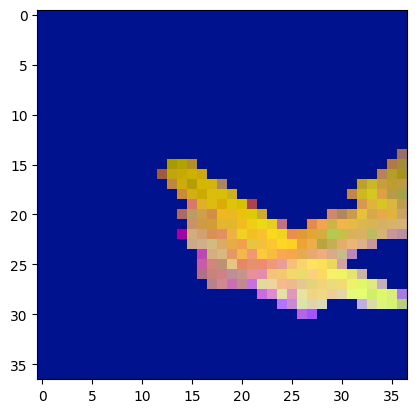

In [47]:
plane_pca = pcas[0]
foreground_mask = np.where(plane_pca[:, 0] > 20, 1, 0).reshape(PATCH_H, PATCH_W, 1)
plane_pca_fg = plane_pca.reshape(PATCH_H, PATCH_W, 3) * foreground_mask
plane_pca_fg_norm = normalize_pca_img(plane_pca_fg)
plt.imshow(plane_pca_fg_norm)

One of the more interesting visualisations in the paper was the the cross comparisons of features learned between images of the same category. To do this they performed thresholding of the PCA of the single images as above, then computed the PCA of the remaining features across all the images togther. They then reprojected and plotted (again the 3 principal components are the RGB channels). 

In [121]:
dog_tensors, dog_imgs,  = [], []
dog_features, dog_features_fg = [], []
fg_masks = []
dog_pcas = []

for i in range(1, 4):
    tensor, img = load_image(f"data/d{i}.jpg", transform)
    tensor = tensor.cuda()
    dog_tensors.append(tensor)
    dog_imgs.append(img)

    features_arr = get_img_features(tensor, dinov2_vits14).squeeze(0)
    dog_features.append(features_arr)

    dog_pca = get_pca_features(features_arr, PATCH_H, PATCH_W, FEAT_DIM)
    dog_pcas.append(dog_pca)

    fg = np.where(dog_pca[:, 0] < -5)
    fg_mask = np.where(dog_pca[:, 0] < -5, 1, 0)
    fg_masks.append(fg_mask)
    dog_features_fg.append(features_arr[fg])

We compute a shared PCA over the foreground features of the 3 dogs. We then transform the foreground patches and display them. 

(1985, 384)


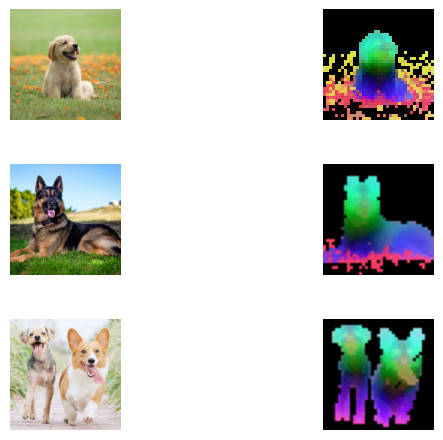

In [122]:
concat_features_flat = np.concatenate(dog_features_fg, 0)
print(concat_features_flat.shape)
shared_pca = PCA(n_components=3)
shared_pca.fit(concat_features_flat)

fig, axs = plt.subplots(3, 2)
plt.tight_layout()
for i, feat in enumerate(dog_features_fg):
    shared_repr = shared_pca.transform(feat)
    norm_fg_pca = normalise_pca(shared_repr)
    out = np.zeros((PATCH_H * PATCH_W, 3))
    nonzero_idx = 0
    # slow implementation but w/e
    for j, val in enumerate(fg_masks[i]):
        if val == 1:
            out[j, :] = norm_fg_pca[nonzero_idx, :]
            nonzero_idx += 1
    axs[i, 0].imshow(dog_imgs[i])
    axs[i, 0].set_axis_off()
    axs[i, 1].imshow(out.reshape(PATCH_H, PATCH_W, 3))
    axs[i, 1].set_axis_off()
